<a href="https://colab.research.google.com/github/bartexx37/DeepLearning/blob/main/CityScapes_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. **Download and preprocess Data**
- Data from Kaggle: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
- Data description: https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py

In [2]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
#How many classes
NUM_OF_CLASSES = len(labels)
NUM_OF_CLASSES

35

In [4]:
#Getting access to Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##IMPORTS

In [5]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

**TAKE FILES FROM GOOGLE DRIVE**

In [6]:
import zipfile
#Unzip the fine annotation data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/archive.zip")
zip_ref.extractall()
zip_ref.close()

##DATA EXPLORATORY

In [7]:
train = "/content/cityscapes_data/train"
val = "/content/cityscapes_data/val"
len(os.listdir(train)), len(os.listdir(val))

(2975, 500)

In [8]:
for dirpath, dirnames, filenames in os.walk("/content/cityscapes_data"):
  print(f"There are {len(dirnames)} directories with {len(filenames)} images in {dirpath}")

There are 3 directories with 0 images in /content/cityscapes_data
There are 0 directories with 2975 images in /content/cityscapes_data/train
There are 0 directories with 500 images in /content/cityscapes_data/val
There are 2 directories with 0 images in /content/cityscapes_data/cityscapes_data
There are 0 directories with 2975 images in /content/cityscapes_data/cityscapes_data/train
There are 0 directories with 500 images in /content/cityscapes_data/cityscapes_data/val


(256, 512, 3)


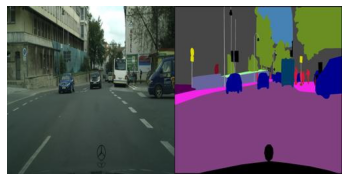

In [9]:

random_image = random.sample(os.listdir(train),1)
img = mpimg.imread(train + "/" + random_image[0])
plt.imshow(img)
plt.axis(False)
print(img.shape)

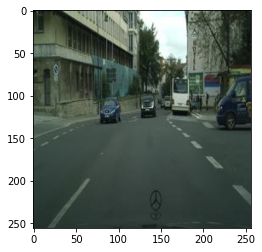

In [10]:
plt.imshow(img[:,:256,:])

##DATA PREPROCESSING

In [11]:
#Function to split data
def splitting_data(img_path):
  img_arr=[]
  mask_arr=[]
  for img in os.listdir(img_path):
    img_arr.append(mpimg.imread(img_path+"/"+img)[:,:256,:])
    mask_arr.append(mpimg.imread(img_path+"/"+img)[:,256:,:])
  return img_arr,mask_arr

In [12]:
#Splitting training data
img_train,mask_train = splitting_data(train)
img_train[5].shape, mask_train[5].shape, len(img_train), len(mask_train)

((256, 256, 3), (256, 256, 3), 2975, 2975)

In [13]:
#Splitting validation data
img_val,mask_val = splitting_data(val)
img_val[5].shape, mask_val[5].shape, len(img_val),len(mask_val)

((256, 256, 3), (256, 256, 3), 500, 500)

In [14]:
#Function to visualize images
def visualize_random_img_mask(images,masks):
  for i in range(3):
    x = random.randint(0,len(images))
    plt.figure(figsize=[20,20])
    plt.subplot(2,4,i+1)
    plt.imshow(images[x])
    plt.subplot(2,4,i+2)
    plt.imshow(masks[x])
    plt.axis(False);

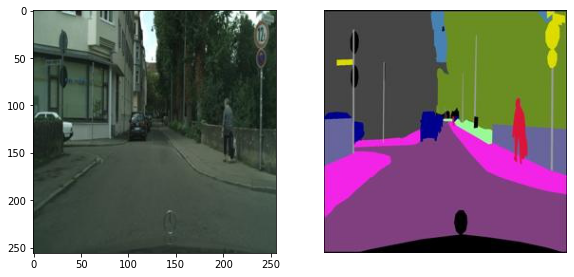

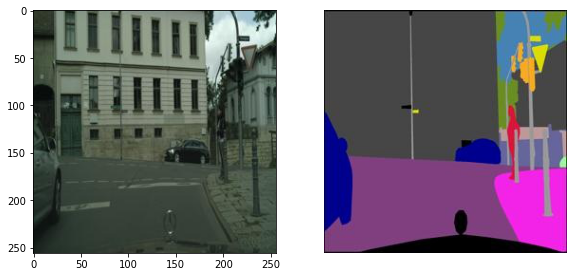

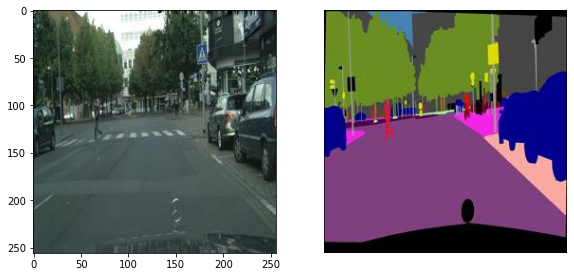

In [15]:
#Visualize train images 
visualize_random_img_mask(img_train,mask_train)

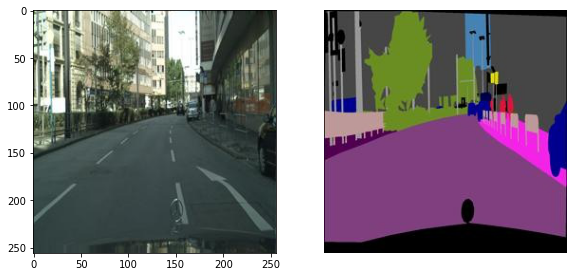

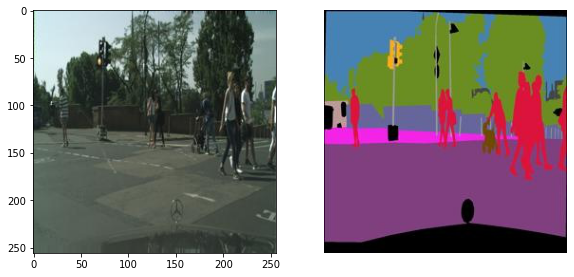

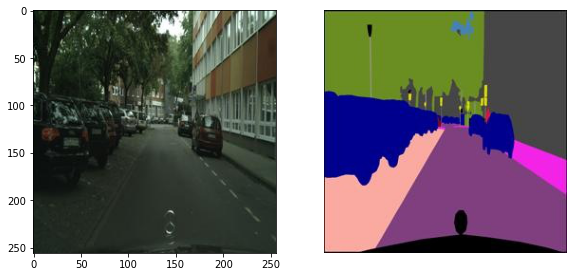

In [16]:
#Visualize validation images
visualize_random_img_mask(img_val,mask_val)

**Encode mask - preparing for deep learning**

In [17]:
#Mapping to encode
id2color = { label.id : np.asarray(label.color) for label in labels }
#Mask encoding - 35 classes
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   
    #Pętla przechodzi zaczynając od 10000 - na pewno większych. Przypisuje pierwsze id (no i nadpisuje te dystanse/id), następnie przechodzi przez kolejne klasy i sprawdza, czy kolejny
    #dystans nie jest mniejszy niż ostatnio przypisany. Jeżeli tak - to nadpisuje nowym id, jeżeli nie to zostaje poprzednio przypisana klasa. 
    #Sprawdzenie polega na zsumowanych kwadratach różnich pod pierwiastekiem (Dystans euklidesowy)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))#reshape for correct shape
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category) # Pixels where distance is smaller will have id exchanged
    
    return closest_category

In [18]:
catego = np.full([mask_val[0].shape[0],mask_val[0].shape[1]],None)
#for mask in mask_val:
for id, color in id2color.items():
  for row in range(mask_val[0].shape[0]):
    for col in range(mask_val[0].shape[1]):
      if np.all(mask_val[0][row][col] == color):
        catego[row][col] == id
catego
        #if id == 3 and row==2 and col==10:
         # print(mask[row][col])
#It looks like RGB colors given in github don't fit exacly to real ones..
#That's why everything is still 'None' - Thats the reason why linalg.norm is used to encode 

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [19]:
#Encoding training masks
train_mask_encoded=[]
for mask in (mask_train):
  train_mask_encoded.append(find_closest_labels_vectorized(mask, id2color))


In [20]:
#Encoding validation masks
val_mask_encoded=[]
for mask in (mask_val):
  val_mask_encoded.append(find_closest_labels_vectorized(mask,id2color))


In [21]:
print(f"Sample shape of train encoded mask{train_mask_encoded[0].shape} \n Length of train encoded mask: {len(train_mask_encoded)} - type {type(train_mask_encoded)}")
print(f"Sample shape of val encoded mask{val_mask_encoded[0].shape} \n Length of val encoded mask: {len(val_mask_encoded)} - type {type(val_mask_encoded[0])}")

Sample shape of train encoded mask(256, 256) 
 Length of train encoded mask: 2975 - type <class 'list'>
Sample shape of val encoded mask(256, 256) 
 Length of val encoded mask: 500 - type <class 'numpy.ndarray'>


**Visualize encoded masks to validate correctness**

In [22]:
# To visualize, it has to be decoded to corresponding colors
def decode_and_visualize(mask_encoded,mask,image):#,mask,image
  random_ = random.randint(0,len(mask_encoded))
  decoded_mask = np.zeros([mask_encoded[random_].shape[0],mask_encoded[random_].shape[1],3])
  random_mask = mask_encoded[random_]
  for row in range(random_mask.shape[0]):
    for col in range(random_mask.shape[1]):
        decoded_mask[row,col,:] = id2color[random_mask[row,col]]#Taking color from dictionary according to its class
        decoded_mask = decoded_mask.astype("uint8")
  print(type(decoded_mask))
  #print(decoded_mask)
  print(decoded_mask.shape, image[random_].shape,mask[random_].shape )
  #Plot
  plt.figure(figsize=[20,15])
  plt.subplot(1,3,1)
  plt.imshow(image[random_])
  plt.title("IMAGE")
  plt.subplot(1,3,2)
  plt.imshow(mask[random_])
  plt.title("MASK")
  plt.subplot(1,3,3)
  plt.imshow(decoded_mask)
  plt.title("ENCODED MASK")
  plt.axis(False)

<class 'numpy.ndarray'>
(256, 256, 3) (256, 256, 3) (256, 256, 3)


(None, array([0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], dtype=object), 29, 29)

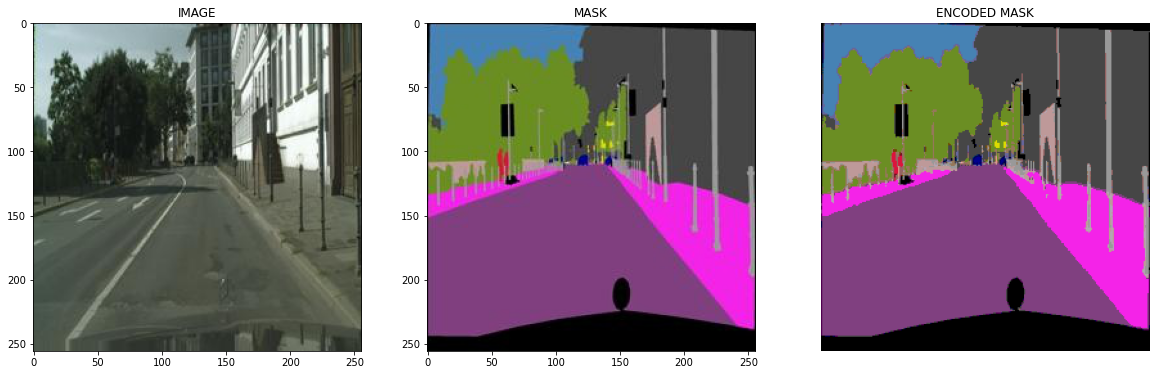

In [23]:
#Visualize validation - encoded - masks
decode_and_visualize(val_mask_encoded,mask_val,img_val), np.unique(val_mask_encoded), len(np.unique(val_mask_encoded)), len(np.unique(train_mask_encoded))
# 29 Classes

<class 'numpy.ndarray'>
(256, 256, 3) (256, 256, 3) (256, 256, 3)


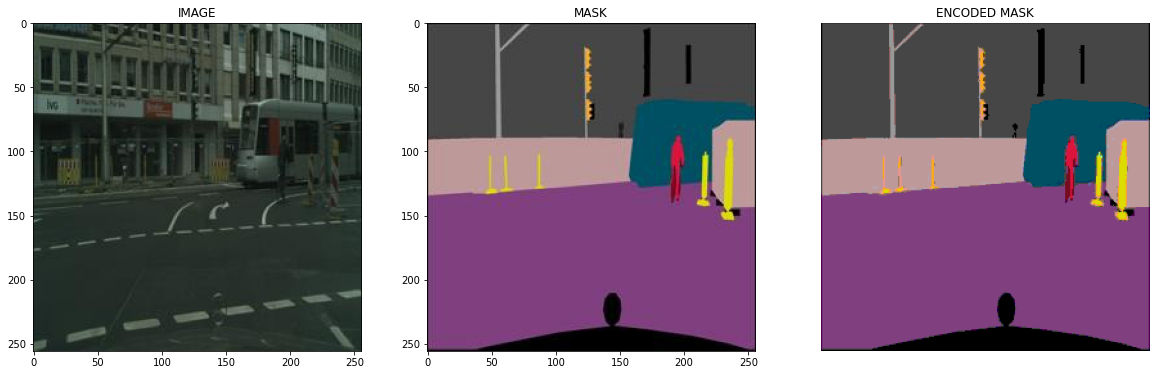

In [24]:
#Visualize training - encoded - masks
decode_and_visualize(train_mask_encoded,mask_train,img_train)

** Preprocess **(img_train ,train_mask_encoded)** and **(img_val,val_mask_encoded)** to appropriate format for faster training**

In [28]:
def preprocess_img(image,img_size):
  img = tf.image.resize(img, [img_size,img_size])
  img /= 255.0
  return img

img_train_ds = tf.data.Dataset.from_tensor_slices(img_train)
img_val_ds = tf.data.Dataset.from_tensor_slices(img_val)

#x= preprocessing.Rescaling(1/255.)(X) or in augmentation layer  - To normalize ?

#img_train_ds = img_train_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(tf.data.AUTOTUNE)
#img_val_ds = img_val_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(tf.data.AUTOTUNE)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 11, 11, ..., 11, 11, 11],
       [0, 11, 11, ..., 21, 16, 0],
       ...,
       [27, 6, 6, ..., 7, 7, 6],
       [0, 27, 27, ..., 11, 11, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

##Mixed Precision Training
- For faster training

In [33]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#Global data policy to mixed precision - mixing float16 and float32 if possible
mixed_precision.global_policy()

<Policy "mixed_float16">

#Check

In [80]:
np.full([mask_train[1].shape[0], mask_train[1].shape[1]], 10000).shape

(256, 256)

In [93]:
mask_train[0]

array([[[  5,   4,  38],
        [  0,   1,   7],
        [  7,  17,   0],
        ...,
        [  0,   0,   0],
        [  1,   1,   1],
        [  7,   7,   7]],

       [[  3,   3,  27],
        [  4,  11,   3],
        [ 58,  71,  28],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  2,   2,   2]],

       [[  0,   1,   7],
        [  2,  12,   0],
        [ 86, 106,  37],
        ...,
        [  2,   2,   2],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   2,   1],
        [  0,   2,   1],
        [  0,   2,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   2,   0],
        [  0,   2,   0],
        [  0,   2,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [65]:
id2color.items()

dict_items([(0, array([0, 0, 0])), (1, array([0, 0, 0])), (2, array([0, 0, 0])), (3, array([0, 0, 0])), (4, array([0, 0, 0])), (5, array([111,  74,   0])), (6, array([81,  0, 81])), (7, array([128,  64, 128])), (8, array([244,  35, 232])), (9, array([250, 170, 160])), (10, array([230, 150, 140])), (11, array([70, 70, 70])), (12, array([102, 102, 156])), (13, array([190, 153, 153])), (14, array([180, 165, 180])), (15, array([150, 100, 100])), (16, array([150, 120,  90])), (17, array([153, 153, 153])), (18, array([153, 153, 153])), (19, array([250, 170,  30])), (20, array([220, 220,   0])), (21, array([107, 142,  35])), (22, array([152, 251, 152])), (23, array([ 70, 130, 180])), (24, array([220,  20,  60])), (25, array([255,   0,   0])), (26, array([  0,   0, 142])), (27, array([ 0,  0, 70])), (28, array([  0,  60, 100])), (29, array([ 0,  0, 90])), (30, array([  0,   0, 110])), (31, array([  0,  80, 100])), (32, array([  0,   0, 230])), (33, array([119,  11,  32])), (34, array([  0,   0

In [92]:
blabla=[]
for id, color in id2color.items():
  blabla.append(color.reshape([1,1,-1]))
blabla[9]

array([[[250, 170, 160]]])

In [64]:
cos[0]

array([[27, 0, 0, ..., 0, 0, 0],
       [0, 0, 11, ..., 0, 0, 0],
       [0, 0, 21, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [109]:
(mask_train[0]-blabla[9])

array([[[-245, -166, -122],
        [-250, -169, -153],
        [-243, -153, -160],
        ...,
        [-250, -170, -160],
        [-249, -169, -159],
        [-243, -163, -153]],

       [[-247, -167, -133],
        [-246, -159, -157],
        [-192,  -99, -132],
        ...,
        [-250, -170, -160],
        [-250, -170, -160],
        [-248, -168, -158]],

       [[-250, -169, -153],
        [-248, -158, -160],
        [-164,  -64, -123],
        ...,
        [-248, -168, -158],
        [-250, -170, -160],
        [-250, -170, -160]],

       ...,

       [[-250, -170, -160],
        [-250, -170, -160],
        [-250, -170, -160],
        ...,
        [-250, -170, -160],
        [-250, -170, -160],
        [-250, -170, -160]],

       [[-250, -168, -159],
        [-250, -168, -159],
        [-250, -168, -159],
        ...,
        [-250, -170, -160],
        [-250, -170, -160],
        [-250, -170, -160]],

       [[-250, -168, -160],
        [-250, -168, -160],
        [-250, -

In [110]:
np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0])

array([17.8913819 , 18.39386187, 18.13068578, 18.10036627, 18.29892655,
       18.33711829, 18.26587046, 18.31160226, 18.28630622, 18.20766954,
       18.31160226, 18.16661104, 18.33711829, 18.37579814, 17.77002119,
       18.16273185, 18.34995784, 18.33711829, 18.32433297, 18.31160226,
       18.31160226, 18.31160226, 18.32433297, 18.32433297, 18.32433297,
       18.32433297, 18.29892655, 18.29892655, 18.29892655, 18.29892655,
       18.31160226, 18.31160226, 18.38879813, 18.36870292, 18.42811296,
       18.46947967, 18.40746501, 18.30267902, 18.2586052 , 18.28238001,
       18.29831452, 18.34611285, 18.39643232, 18.40842692, 18.40842692,
       18.40842692, 18.40842692, 18.40842692, 18.40277353, 18.40277353,
       18.40277353, 18.40277353, 18.40277353, 18.40277353, 18.40277353,
       18.40277353, 18.40277353, 18.40277353, 18.40277353, 18.40277353,
       18.40277353, 18.40277353, 18.40277353, 18.40277353, 18.40277353,
       18.40277353, 18.40277353, 18.40277353, 18.40277353, 18.40

In [116]:
 closest_distance = np.full([mask_train[1].shape[0], mask_train[1].shape[1]], 10000)
 closest_distance > np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [118]:
np.where( closest_distance > np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0]), np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0]), closest_distance)


array([[17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611],
       [17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611],
       [17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611],
       ...,
       [17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611],
       [17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611],
       [17.8913819 , 18.39386187, 18.13068578, ..., 18.49466484,
        18.44877138, 18.17119611]])